# Hướng dẫn chạy thuật toán
Để sử dụng được thuật toán này, vui lòng user tải file G_IFCM.ipynb lên GGcolab theo các bước sau:


1.   Người dùng tìm kiếm GG Colab rồi chọn trang web sau.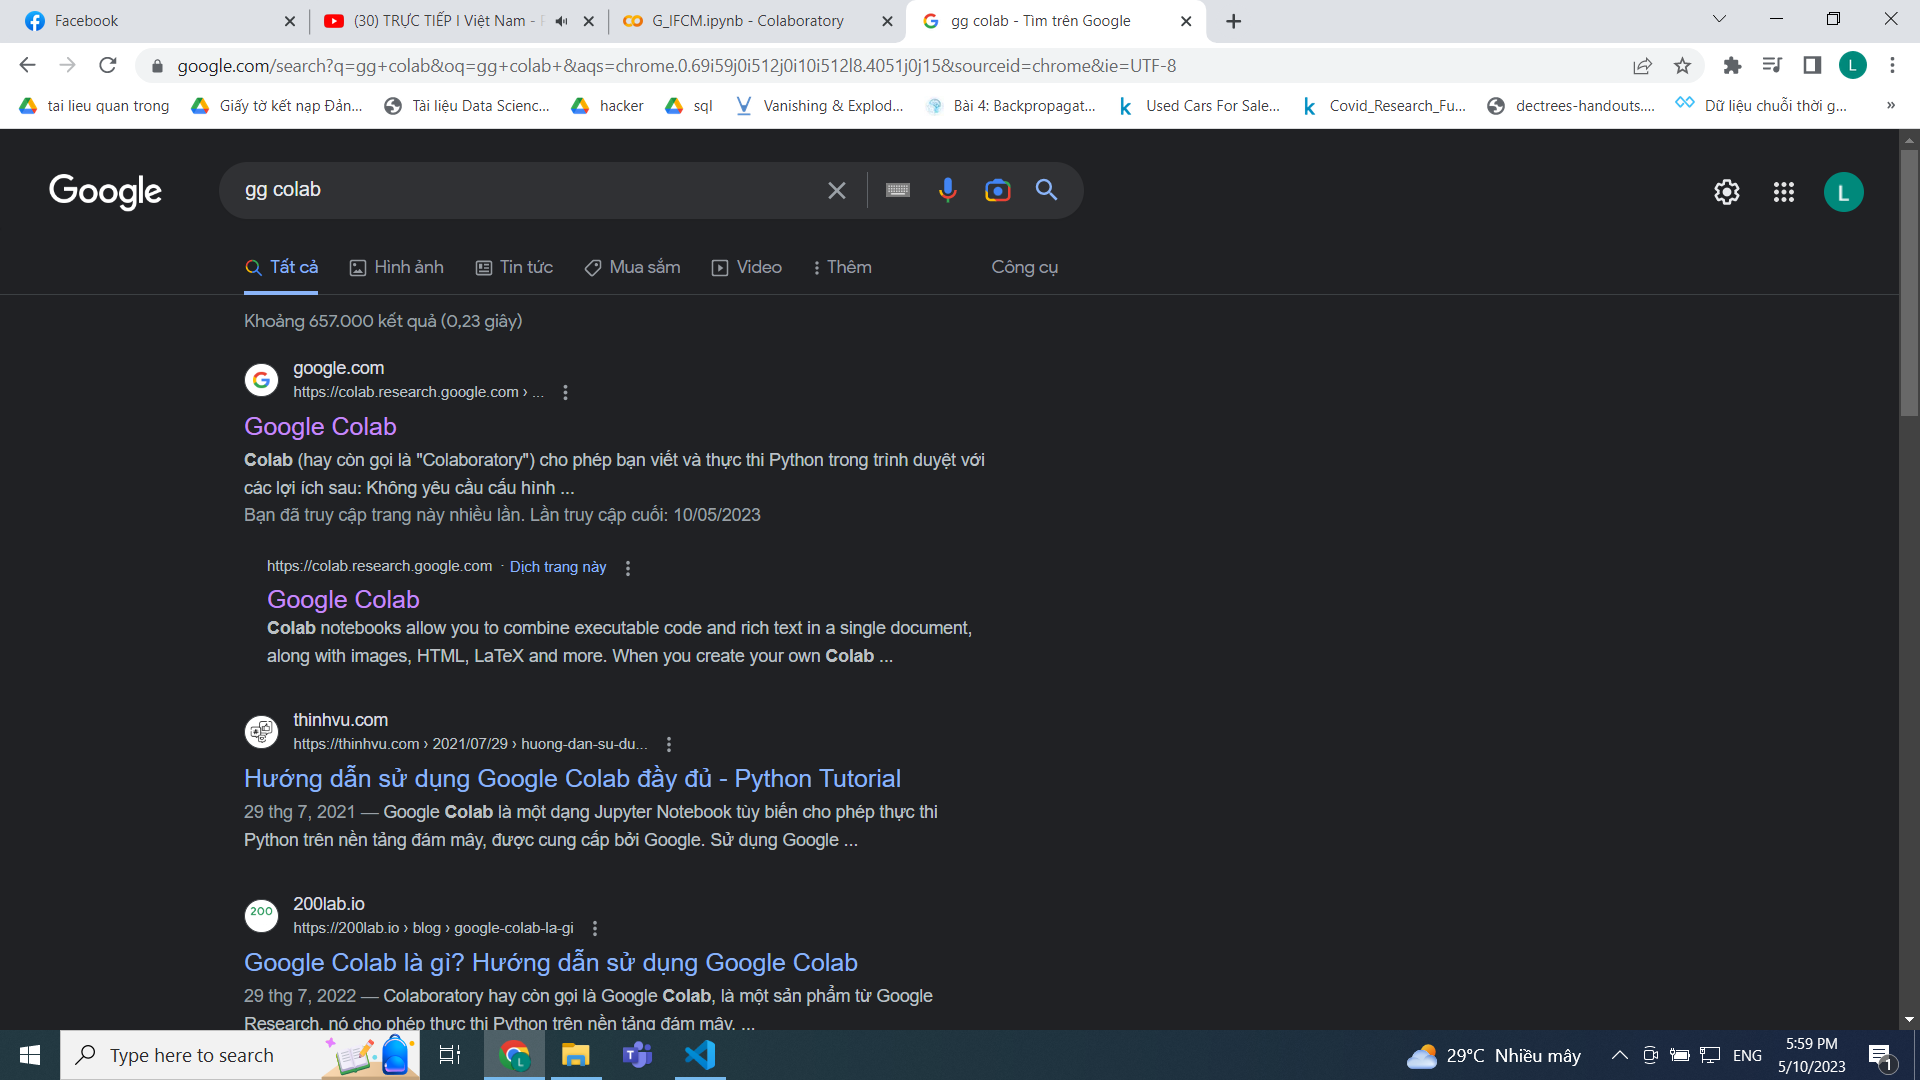
2.   Sau khi và GG Colab, ta chọn ô Tải lên trên màn hình chính rồi tải file G_IFCM lên để sử dụng.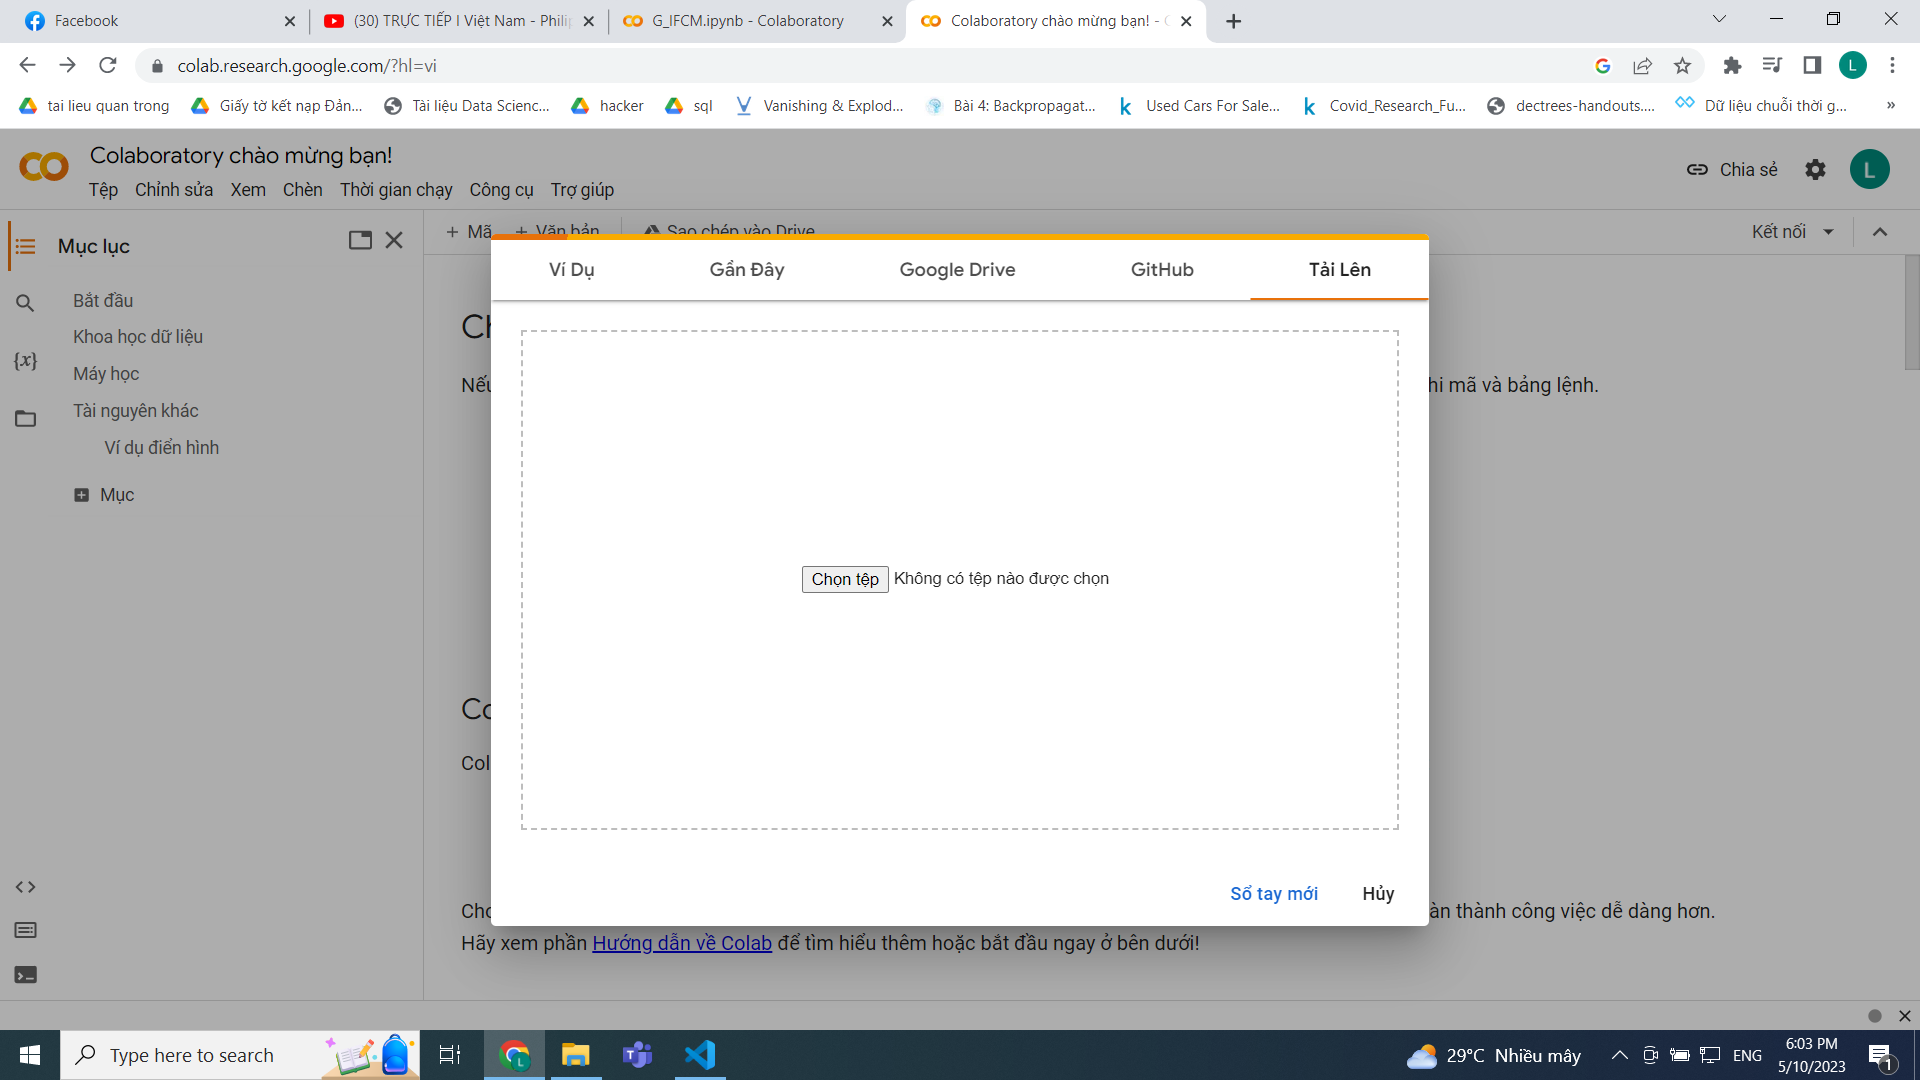
3. Đầu tiên user cần phải tải dataset lên.
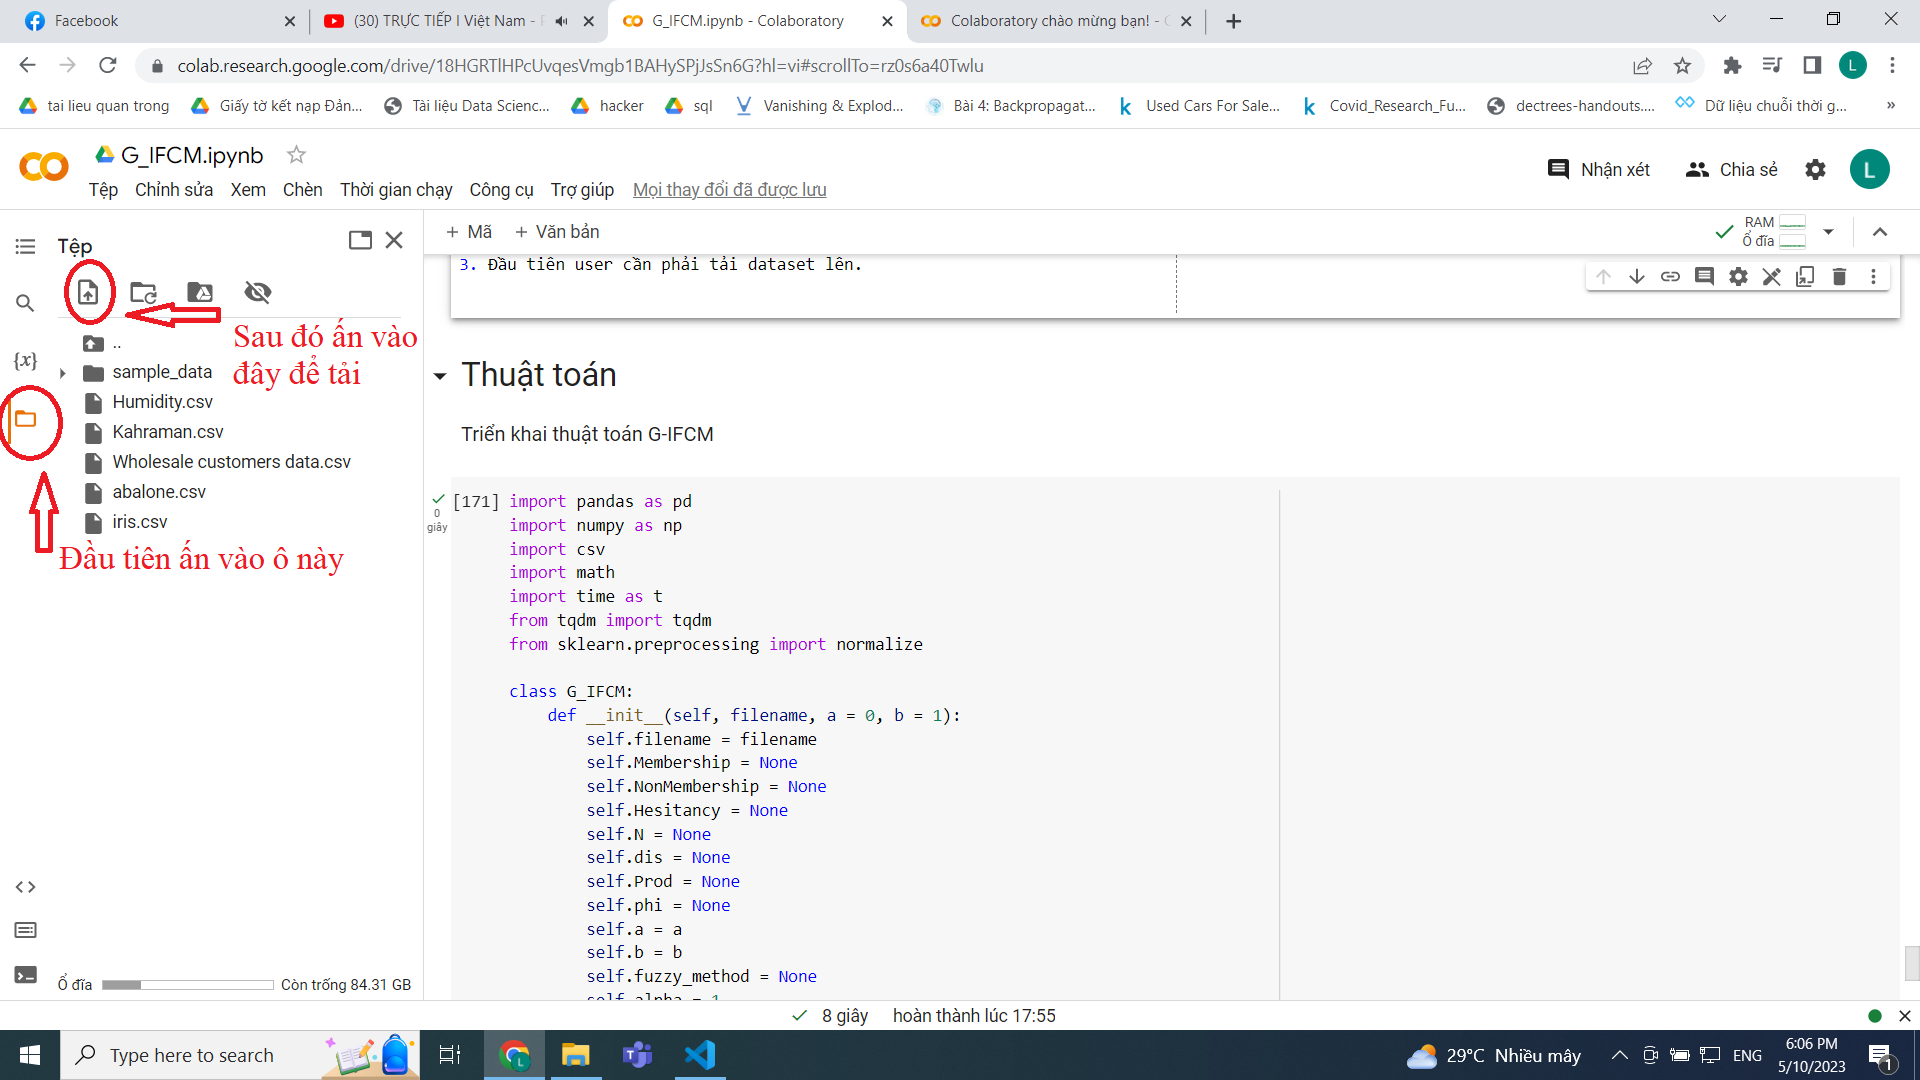
4. Sau đó người dùng cần chạy ô thuật toán đầu tiên để có thể sử dụng thuật toán.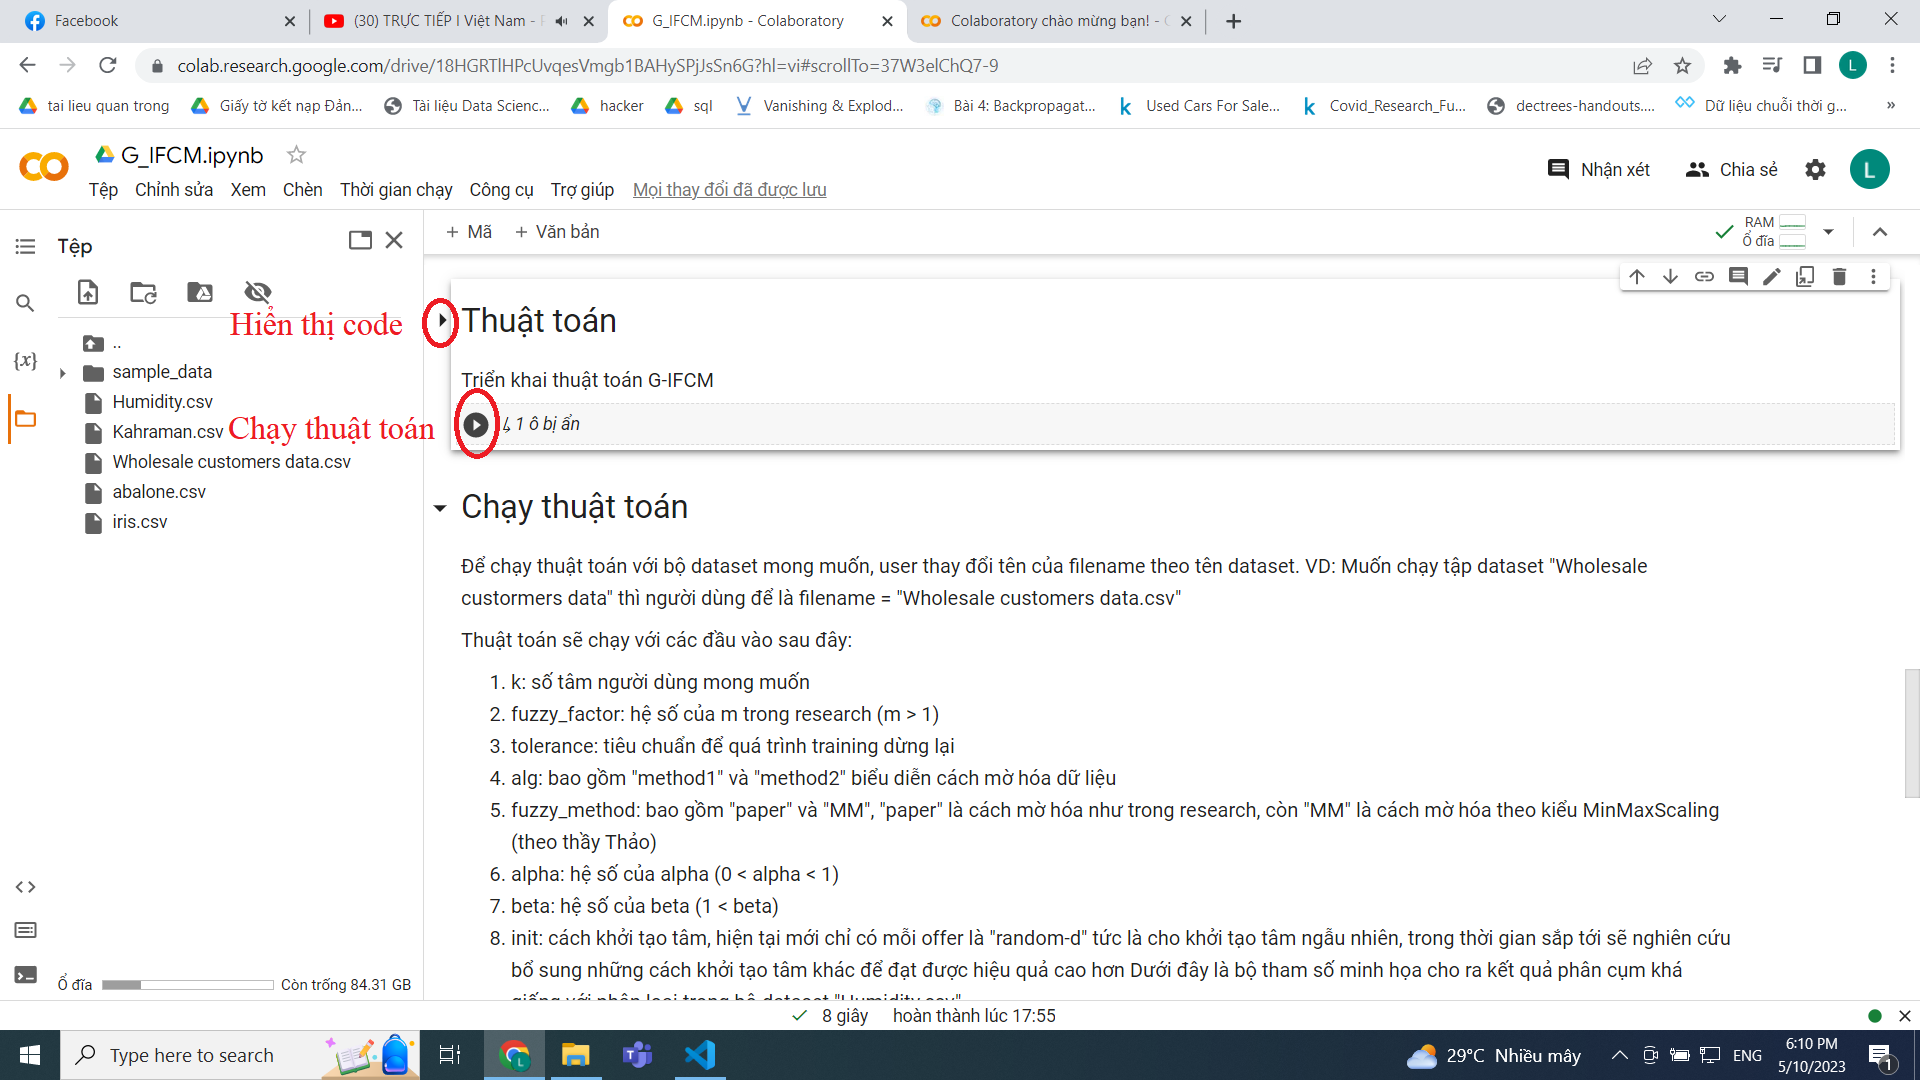
5. Sau đó hãy nhập tham số để sử dụng theo mong muốn của bạn.

# Thuật toán
Triển khai thuật toán G-IFCM

In [2]:
import pandas as pd
import numpy as np
import csv
import math
import time as t
from tqdm import tqdm
from sklearn.preprocessing import normalize
from numpy import random
from itertools import permutations

class G_IFCM:
    def __init__(self, filename, a = 0, b = 1):
        self.filename = filename
        self.Membership = None
        self.NonMembership = None
        self.Hesitancy = None
        self.N = None
        self.dis = None
        self.Prod = None
        self.phi = None
        self.a = a
        self.b = b
        self.numberLabel = None
        self.fuzzy_method = None
        self.alpha = 1
        self.beta = 1
        self.k = 0
        self.fuzzy_factor = 1
        self.tolerance = 0
        self.alg = None
        self.clusterM = None
        self.clusterN = None
        self.clusterH = None
        self.U = None
        self.init = None
        self.iter = 0
        self.eval = None
        self.diffPC = None
        self.diffCC = None

    def PreProcessing(self):
        self.data = pd.read_csv(self.filename, delimiter = None)
        self.data = self.data.reset_index(drop = True)
        self.data = self.data[:]
        self.m = self.data.shape[0]
        self.numberHeader = self.data.shape[1]
        self.columns = self.data.columns
        if "Label" in self.columns:
          uniqueLabel = self.data["Label"].unique()
          uniqueLabel.sort()
          self.numberLabel = len(uniqueLabel)
          dic = {}
          i = 0
          for label in uniqueLabel:
            dic[label] = i
            i += 1
          self.data["nLabel"] = self.data.Label.map(dic)
          self.label = self.data["nLabel"]
          self.data = self.data.drop(["nLabel", "Label"], axis = 1)
          self.numberHeader -= 1

    def FuzzyData(self):
        t1 = t.time()
        self.maxValueCol = self.data.max().values
        self.minValueCol = self.data.min().values
        self.data = self.data.to_numpy()
        if self.alg == 'method1':
            self.N = (self.data - self.minValueCol) / (self.maxValueCol - self.minValueCol)
        else:
            self.N = np.copy(self.data)
        self.dis = []
        for i in tqdm(self.N):
            d = np.sqrt(np.einsum("ij, ij -> i", i - self.N, i - self.N))
            self.dis.append(d)
        self.dis = np.array(self.dis)
        self.dis = self.dis.reshape((self.m, self.m))
        # print(self.dis)
        self.Prod = np.matmul(self.dis, self.N)
        if self.alg == 'method2':
            self.Prod = 1 / self.Prod
            self.Prod = pd.DataFrame(self.Prod)
            maxCol = self.Prod.max().values
            minCol = self.Prod.min().values
            self.Prod = (self.Prod - minCol) / (maxCol - minCol)
            sumM = self.Prod + self.data
            print(sumM)
            sumM = pd.DataFrame(sumM)
            maxCol = sumM.max().values
            minCol = sumM.min().values
            sumM = (sumM - minCol) / (maxCol - minCol)
        if self.alg == 'method1':
            if self.fuzzy_method[:2] == "MM":
                self.Prod = pd.DataFrame(self.Prod)
                maxCol = self.Prod.max().values
                minCol = self.Prod.min().values
                self.Prod = np.array(self.Prod)
                self.Membership = (self.Prod - minCol) / (maxCol - minCol)
                self.NonMembership = (1 - self.Membership) / (1 + self.Membership)
            elif self.fuzzy_method == "paper":
                self.Membership = (1 / self.Prod)
                self.NonMembership = (1 - np.power(self.Membership, self.alpha))
                self.NonMembership = np.power(self.NonMembership, 1 / self.alpha)
        else:
            self.Membership = np.power(sumM, self.beta)
            if self.fuzzy_method == 'paper':
                self.NonMembership = 1 - np.power(self.Membership, self.alpha * self.beta)
                self.NonMembership = np.power(self.NonMembership, 1 / self.alpha)
            else:
                self.Membership = pd.DataFrame(self.Membership)
                maxCol = self.Membership.max().values
                minCol = self.Membership.min().values
                self.Membership = pd.array(self.Membership)
                self.NonMembership = (self.Membership - minCol) / (maxCol - minCol)
        self.Hesitancy = 1 - self.Membership - self.NonMembership
        t2 = t.time()

    def InitCluster(self):
        self.clusterM = []
        self.clusterN = []
        self.clusterH = []
        if self.init == 'means++':
            idxCluster = []
            for k in range(self.k):
              if k == 0:
                k1 = random.randint(self.m)
                idxCluster.append(k1)
              else:
                lst = np.array([0 for j in range(self.m)])
                for clus in idxCluster:
                  lst = lst + self.dis[clus]
                sortL = np.sort(lst)
                d = 0
                x = self.m - 1
                while d == 0:
                  res = np.where(lst == sortL[x])
                  res = res[0]
                  for can in res:
                    if can not in idxCluster:
                      idxCluster.append(can)
                      d = 1
                      break
                    else:
                      continue
                  x -= 1
            for clus in idxCluster:
              self.clusterM.append(self.Membership[clus])
              self.clusterN.append(self.NonMembership[clus])
              self.clusterH.append(self.Hesitancy[clus])
        elif self.init == 'random-d':
            for i in range(self.k):
                cluster = np.random.dirichlet(np.ones(3), size = self.numberHeader).T
                self.clusterM.append(cluster[0])
                self.clusterN.append(cluster[1])
                self.clusterH.append(cluster[2])
        else:
            pass
        self.clusterM = np.array(self.clusterM)
        self.clusterN = np.array(self.clusterN)
        self.clusterH = np.array(self.clusterH)
        self.U = np.ones(shape = (self.m, self.k)) / self.k


    def Training(self):
        d = 0
        x = 0
        while d == 0:
            s = "Matrix U"
            Mem = []
            Non = []
            Hes = []
            coeff = 1
            if self.measure.strip().lower() == 'default':
              for j in self.Membership:
                  s1 = np.einsum("ij, ij -> i", j - self.clusterM, j - self.clusterM)
                  Mem.append(s1)
              for j in self.NonMembership:
                  s2 = np.einsum("ij, ij -> i", j - self.clusterN, j - self.clusterN)
                  Non.append(s2)
              for j in self.Hesitancy:
                  s3 = np.einsum('ij, ij -> i', j - self.clusterH, j - self.clusterH)
                  Hes.append(s3)
              coeff = 2 * self.m
            elif self.measure.strip().lower() == 'manhattan':
              zerosM = np.zeros((self.k, self.numberHeader))
              onesR = np.ones(self.numberHeader)
              for j in self.Membership:
                  s1 = np.einsum("ij, ij -> i", np.abs(j - self.clusterM), onesR - zerosM)
                  Mem.append(s1)
              for j in self.NonMembership:
                  s2 = np.einsum("ij, ij -> i", np.abs(j - self.clusterN), onesR - zerosM)
                  Non.append(s2)
              for j in self.Hesitancy:
                  s3 = np.einsum('ij, ij -> i', np.abs(j - self.clusterH), onesR - zerosM)
                  Hes.append(s3)
              coeff = self.m
            elif self.measure.strip().lower() == 'mincowski':
              zerosM = np.zeros((self.k, self.numberHeader))
              onesR = np.ones(self.numberHeader)
              for j in self.Membership:
                  s1 = np.einsum("ij, ij -> i", np.power(j - self.clusterM, self.p), onesR - zerosM)
                  Mem.append(s1)
              for j in self.NonMembership:
                  s2 = np.einsum("ij, ij -> i", np.power(j - self.clusterN, self.p), onesR - zerosM)
                  Non.append(s2)
              for j in self.Hesitancy:
                  s3 = np.einsum('ij, ij -> i', np.power(j - self.clusterH, self.p), onesR - zerosM)
                  Hes.append(s3)
              coeff = self.m * self.p
            Mem = np.abs(np.array(Mem))
            Non = np.abs(np.array(Non))
            Hes = np.abs(np.array(Hes))
            # if self.measure.strip().lower() == 'mincowski':
            #   Mem = np.power(Mem, 1 / self.p)
            #   Non = np.power(Non, 1 / self.p)
            #   Hes = np.power(Hes, 1 / self.p)
            s = Mem + Non + Hes
            s = np.where(s == 0, 10 ** (-5), s)
            s = s / coeff
            s = np.power(s, 1 / (self.fuzzy_factor - 1))
            self.U = normalize(s, axis = 1, norm = 'l1')
            self.U = 1 / self.U
            self.U = normalize(self.U, axis = 1, norm = 'l1')
            s = np.copy(self.U)
            s = np.power(s, self.fuzzy_factor)
            sumRow = s.sum(axis = 0)
            NclusterM = (np.matmul(s.T, self.Membership).T / sumRow).T
            NclusterN = (np.matmul(s.T, self.NonMembership).T / sumRow).T
            NclusterH = (np.matmul(s.T, self.Hesitancy).T / sumRow).T
            diffM = self.clusterM - NclusterM
            diffN = self.clusterN - NclusterN
            diffH = self.clusterH - NclusterH
            diff = np.power(diffM, 2) + np.power(diffN, 2) + np.power(diffH, 2)
            diffSum = diff.sum(axis = 1)
            diffSum = diffSum / self.numberHeader
            diffSum = np.sqrt(diffSum)
            diffSum = diffSum.sum(axis = 0)
            diffSum /= self.k
            # print("Criterion: ", diffSum)
            if (diffSum <= self.tolerance):
                d = 1
            self.clusterM = np.copy(NclusterM)
            self.clusterN = np.copy(NclusterN)
            self.clusterH = np.copy(NclusterH)

    def Evaluation(self, eval):
        res = "Result"
        Mem = []
        Non = []
        Hes = []
        for j in self.Membership:
            s1 = np.einsum("ij, ij -> i", j - self.clusterM, j - self.clusterM)
            Mem.append(s1)
        for j in self.NonMembership:
            s2 = np.einsum("ij, ij -> i", j - self.clusterN, j - self.clusterN)
            Non.append(s2)
        for j in self.Hesitancy:
            s3 = np.einsum('ij, ij -> i', j - self.clusterH, j - self.clusterH)
            Hes.append(s3)
        Mem = np.array(Mem)
        Non = np.array(Non)
        Hes = np.array(Hes)
        self.diffPC = Mem + Non + Hes
        # self.diffPC = self.diffPC / 3
        MemC = []
        NonC = []
        HesC = []
        for j in self.clusterM:
            _s1 = np.einsum("ij, ij -> i", j - self.clusterM, j - self.clusterM)
            MemC.append(_s1)
        for j in self.clusterN:
            _s2 = np.einsum("ij, ij -> i", j - self.clusterN, j - self.clusterN)
            NonC.append(_s2)
        for j in self.clusterH:
            _s3 = np.einsum('ij, ij -> i', j - self.clusterH, j - self.clusterH)
            HesC.append(_s3)
        MemC = np.array(MemC)
        NonC = np.array(NonC)
        HesC = np.array(HesC)
        self.diffCC = MemC + NonC + HesC
        # self.diifCC = self.diffCC / 3
        if eval.strip().lower() == "pc":
          pc = np.copy(self.U)
          pc = np.power(pc, 2)
          pc = pc.sum(axis = 1)
          pc = pc.sum(axis = 0)
          pc = pc / self.m
          res = pc
        elif eval.strip().lower() == "sc":
          deno = np.multiply(self.U, self.diffPC)
          deno = deno.sum()
          nume = self.diffCC.sum(axis = 0)
          nume = np.matmul(self.U, nume)
          nume = nume.sum()
          res = (deno / nume) ** (1 / 1)
          # res *= (self.k / self.m)
        elif eval.strip().lower() == 'xb':
          deno = np.power(self.U, 2)
          deno = np.multiply(deno, self.diffPC)
          deno = deno.sum()
          deno /= self.m
          sortV = self.diffCC.flatten()
          sortV = list(sortV)
          sortV.sort()
          nume = sortV[self.k]
          res = deno / nume
        elif eval.strip().lower() == 'di':
          newD = np.copy(self.U).T
          newD = pd.DataFrame(newD)
          clasPre = newD.idxmax().values
          self.clusMD = {}
          self.clusND = {}
          self.clusHD = {}
          for i in range(self.k):
            self.clusMD[i] = []
            self.clusND[i] = []
            self.clusHD[i] = []
          for i in range(self.m):
            self.clusMD[clasPre[i]].append(self.Membership[i])
            self.clusND[clasPre[i]].append(self.NonMembership[i])
            self.clusHD[clasPre[i]].append(self.Hesitancy[i])
          for i in range(self.k):
            self.clusMD[i] = np.array(self.clusMD[i])
            self.clusND[i] = np.array(self.clusND[i])
            self.clusHD[i] = np.array(self.clusHD[i])
          maxD = []
          for i in range(self.k):
            Mem = []
            Non = []
            Hes = []
            for j in self.clusMD[i]:
              d = np.einsum('ij, ij -> i', j - self.clusMD[i], j - self.clusMD[i])
              Mem.append(d)
            for j in self.clusND[i]:
              d = np.einsum('ij, ij -> i', j - self.clusND[i], j - self.clusND[i])
              Non.append(d)
            for j in self.clusHD[i]:
              d = np.einsum('ij, ij -> i', j - self.clusHD[i], j - self.clusHD[i])
              Hes.append(d)
            Mem = np.array(Mem)
            Non = np.array(Non)
            Hes = np.array(Hes)
            s = Mem + Non + Hes
            maxS = s.max()
            maxD.append(maxS)
          maxIntra = max(maxD)
          diScore = 9999
          for i in range(self.k):
            for j in range(i + 1, self.k):
              newM = []
              newN = []
              newH = []
              for u in self.clusMD[i]:
                d = np.einsum('ij, ij -> i', u - self.clusMD[j], u - self.clusMD[j])
                newM.append(d)
              for n in self.clusND[i]:
                d = np.einsum('ij, ij -> i', n - self.clusND[j], n - self.clusND[j])
                newN.append(d)
              for h in self.clusHD[i]:
                d = np.einsum('ij, ij -> i', h - self.clusHD[j], h - self.clusHD[j])
                newH.append(d)
              newM = np.array(newM)
              newN = np.array(newN)
              newH = np.array(newH)
              s = newM + newN + newH
              minInter = s.min()
              diScore = min(diScore, minInter / maxIntra)
          res = diScore
        elif eval.strip().lower() == 'ca':
          permu = list(permutations(range(self.numberLabel)))
          clas = []
          s = self.U.tolist()
          for i in range(len(s)):
            clas.append(s[i].index(max(s[i])))
          clas = np.array(clas)
          clas = pd.Series(clas)
          res = 0
          self.trueIdx = []
          for _per in permu:
            acc = 0
            idx = list(_per)
            nDic = {}
            for i in range(self.numberLabel):
              nDic[i] = idx[i]
            nClas = clas.map(nDic)
            for i in range(self.m):
              if self.label[i] == nClas[i]:
                acc += 1
            acc /= self.m
            if res < acc:
              res = acc
              self.trueIdx = idx
        return res

    def Run(self, k, fuzzy_factor, tolerance, alg = "method1", fuzzy_method = "paper", measure = 'default', p = 2, alpha = 1, beta = 1, init = 'normal-d', iter = 1000):
        self.k = k
        self.fuzzy_factor = fuzzy_factor
        self.tolerance = tolerance
        self.fuzzy_method = fuzzy_method
        self.measure = measure
        self.p = p
        self.alpha = alpha
        self.beta = beta
        self.alg = alg
        self.init = init
        self.iter = iter
        self.PreProcessing()
        self.FuzzyData()
        self.InitCluster()
        self.Training()




# Chạy thuật toán
Để chạy thuật toán với bộ dataset mong muốn, user thay đổi tên của filename theo tên dataset.
VD: Muốn chạy tập dataset "Wholesale custormers data" thì người dùng để là
filename = "Wholesale customers data.csv"


Thuật toán sẽ chạy với các đầu vào sau đây:


1.   k: số tâm người dùng mong muốn
2.   fuzzy_factor: hệ số của m trong research (m > 1)
3.   tolerance: tiêu chuẩn để quá trình training dừng lại
4.   alg: bao gồm "method1" và "method2" biểu diễn cách mờ hóa dữ liệu (hiện tại mới chỉ phát triển mờ hóa theo algorithm 1 trong paper)
5.   fuzzy_method: bao gồm "paper" và "MM", "paper" là cách mờ hóa như trong research, còn "MM" là cách mờ hóa theo kiểu MinMaxScaling (theo thầy Thảo)
6. measure: bao gồm "default", "manhattan", "mincowski" tương đương với các thang đo trong báo cáo. Tham số này dùng để chỉ định cách tính khoảng cách khi huấn luyện.
7. p: đây là trường hợp đặc biệt dùng cho thang đo mincowski, chỉ định số mũ của công thức tính khoảng cách. (ưu tiên p >= 2).
6.   alpha: hệ số của alpha (0 < alpha < 1)
7.   beta: hệ số của beta (1 < beta)
8.   init: cách khởi tạo bao gồm "means++" dựa trên việc tham khảo cách khởi tạo tâm của thuật toán k-means++, "random-d" tức là cho khởi tạo tâm ngẫu nhiên.
Dưới đây là bộ tham số minh họa cho ra kết quả phân cụm khá giống với phân loại trong bộ dataset "Humidity.csv"




In [42]:
import time

filename = "Humidity.csv"
t1 = time.time()
a = G_IFCM(filename)
a.Run(k = 2, fuzzy_factor = 1.15, tolerance = 10 ** (-6), fuzzy_method = 'paper', measure = 'mincowski', p = 2, alpha = 0.25, init = 'means++')
t2 = time.time()
clas = []
s = a.U.tolist()
for i in range(len(s)):
  clas.append(s[i].index(max(s[i])))
cls = set(clas)
#In ra số phần tử ở mỗi lớp trong bài toán
for i in cls:
  print(i, ":", clas.count(i))
print("Time execution: " + str(round((t2 - t1) * 10000)/10000) + "s")

100%|██████████| 9752/9752 [00:02<00:00, 3365.55it/s]


0 : 4876
1 : 4876
Time execution: 6.9341s


# Đánh giá
Có các thang đánh giá sau đây (tương đường với tham số eval):

*   Clustering accuracy (CA) - "ca": thang đo này áp dụng đặc biệt cho trường hợp mà tập dataset đã có trước nhãn, ngoài ra thì tập nếu muốn dùng được thang đo này thì số tâm mà người dùng mong muốn phải bắng với số lượng tâm ban đầu trong tập nhãn của dataset.
*   Partition coefficient(PC) - "pc"
*   Partition index(SC) - "sc"
*   Xie-Beni index(XB) - "xb"
*   Dunn separation index(DI) - "di"

Để chạy được ô đánh giá này, người dùng phải chạy được ô Thuật toán, và chạy thuật toán.



In [11]:
a.Evaluation(eval = 'pc')

0.9933469390861358

In [8]:
dataset_name = ["iris.csv", "BreastCancerWisconsin.csv", "OccupancyEstimation.csv", "Humidity.csv"]
lst_clus = [3, 2, 4, 2]
lst_alpha = [(i / 100) for i in range(5, 100, 20)]
lst_method = []
lst_fzz = [(i / 100) for i in range(115, 400, 60)]
lst_measure = []
lst_init = []
eva = ["ca", 'pc', 'sc', 'xb', 'di']
k = len(lst_alpha)
max_res = 0
al = 0
fzz = 0
filename = "BreastCancerWisconsin.csv"
for i in range(k):
  for j in range(k):
    a = G_IFCM(filename)
    a.Run(k = 2, fuzzy_factor = lst_fzz[j], tolerance = 10 ** (-6), fuzzy_method = 'paper', measure = 'mincowski', p = 2, alpha = lst_alpha[i], init = 'means++')
    s = ""
    for _eval in eva:
      res = a.Evaluation(eval = _eval)
      if _eval == 'ca':
        if max_res < res:
          max_res = res
          al = lst_alpha[i]
          fzz = lst_fzz[j]
print(filename + " best result ca: " + str(round(max_res, 4)) + " alpha-m:" + str(al) + "-" + str(fzz))

100%|██████████| 683/683 [00:00<00:00, 23560.60it/s]


BreastCancerWisconsin.csv best result ca: 0.9736 alpha-m:0.25-1.15
